In [70]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
retraining_epochs = 50

def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, data_size, savedir):
    
    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(model_retrain.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
    gmp = GaussianMixturePrior(mixtures, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta), scaling = False)
    gmp.print_batch = False

    print ("Model Name: {}".format(model_retrain.name))
    criterion = nn.MSELoss()
    opt = torch.optim.Adam([
        {'params': model_retrain.parameters(), 'lr': 1e-4},
        {'params': [gmp.means], 'lr': 1e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

    
    for epoch in range(retraining_epochs):
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, opt, criterion, data_loader, tau, temp ** 2)

        if (trueAfterN(epoch, 10)):
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            layer_accuracy(model_retrain, gmp, model_orig, test_data_full, test_labels_full)
            
    if(savedir!=""):
        torch.save(model_retrain, savedir + 'mnist_retrain_{}.m'.format(exp_name))
        with open(savedir + 'mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp, f)
            
    return model_retrain, gmp

def get_layer_data(target_dir, temp, layer, model_name, data_size):
    x_start = 0
    x_end = 60000
    if (data_size == "search"):
        x_start = 40000
        x_end = 50000
    if ("SWSModel" in model_name):
        if (layer == 1):
            layer_model = model_archs.SWSModelConv1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.SWSModelConv2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv1.out"])["conv1.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.SWSModelFC1().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["conv2.out"])["conv2.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 4):
            layer_model = model_archs.SWSModelFC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end]

    if ("LeNet_300_100" in model_name):
        if (layer == 1):
            layer_model = model_archs.LeNet_300_100FC1().cuda()
            input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
            output = get_targets(target_dir, temp, ["fc1.out"])["fc1.out"][x_start:x_end]
        if (layer == 2):
            layer_model = model_archs.LeNet_300_100FC2().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
            output = (get_targets(target_dir, temp, ["fc2.out"])["fc2.out"][x_start:x_end])
        if (layer == 3):
            layer_model = model_archs.LeNet_300_100FC3().cuda()
            input = nn.ReLU()(get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end])
            output = get_targets(target_dir, temp, ["fc3.out"])["fc3.out"][x_start:x_end]


    dataset = torch.utils.data.TensorDataset(input.data, output.data)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return layer_model, loader

def init_retrain_layer(alpha, beta, tau, temp, mixtures, model_name, data_size, layer, savedir = ""):
    test_data_full =  Variable(test_data(fetch = "data")).cuda()
    test_labels_full =  Variable(test_data(fetch = "labels")).cuda()
    val_data_full =  Variable(search_validation_data(fetch = "data")).cuda()
    val_labels_full =  Variable(search_validation_data(fetch = "labels")).cuda()

    model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
    model_orig = torch.load(model_load_dir + model_file + '.m').cuda()

    layer_model, loader = get_layer_data(target_dir, temp, layer, model_name, data_size)

    model, gmp = retrain_layer(layer_model, model_orig, loader, test_data_full, test_labels_full, alpha, beta, tau, mixtures, temp, data_size, model_dir + model_file)
    return model, gmp

In [53]:
def get_init_means(start, end, jump):
    numlist = (list(range(-end, -start + 1, jump)) + list(range(start, end + 1, jump)))
    return [x/100.0 for x in numlist]


In [ ]:
mean_mult = np.array(list(range(retraining_epochs))) - (retraining_epochs-1)/2
mean_mult = -6 * mean_mult/mean_mult.max()
mean_mult = (1.0/(1.0 + np.exp(mean_mult))) * 50000
plt.plot(mean_mult)

In [108]:
mean = 200000
var = 10
zmean = 100000
zvar = 1000
means = get_init_means(8, 60, 9)
print (means)
mixtures = len(means) + 1
temp = 4
tau = 1e-8
data_size = 'search'
model_name = 'LeNet_300_100'

beta = mean/var
alpha = mean * beta
zbeta = zmean/zvar
zalpha = zmean * zbeta

model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")

(x_start, x_end) = (30000, 50000)
layer_model = model_archs.LeNet_300_100FC1().cuda()
input = Variable(train_data(fetch = "data")[x_start:x_end]).cuda()
output = (get_targets(model_file, temp, ["fc1.out"])["fc1.out"][x_start:x_end]).cuda()

test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()

dataset = torch.utils.data.TensorDataset(input.data, output.data)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

state_dict = copy.deepcopy(layer_model.state_dict())
state_dict['fc1.weight'] = full_model.state_dict()['fc1.weight']
state_dict['fc1.bias'] = full_model.state_dict()['fc1.bias']
layer_model.load_state_dict(state_dict)

[-0.6, -0.51, -0.42, -0.33, -0.24, -0.15, 0.08, 0.17, 0.26, 0.35, 0.44, 0.53]


0-component Mean: 100000.0 Variance: 1000.0
Non-zero component Mean: 200000.0 Variance: 10.0
Epoch: 10. Loss: -3579.85


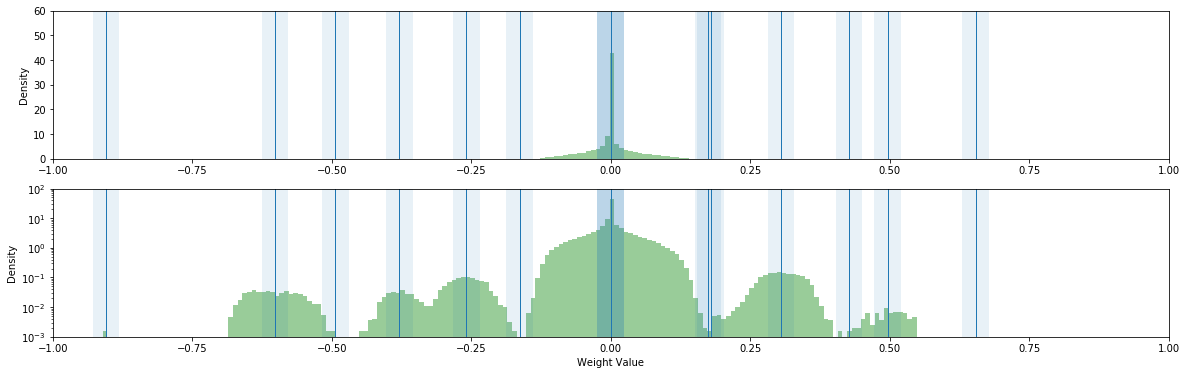

Original: 98.26% - Retrain: 97.31% - Prune: 97.03% - Sparsity: 89.04%
Epoch: 20. Loss: -5308.42


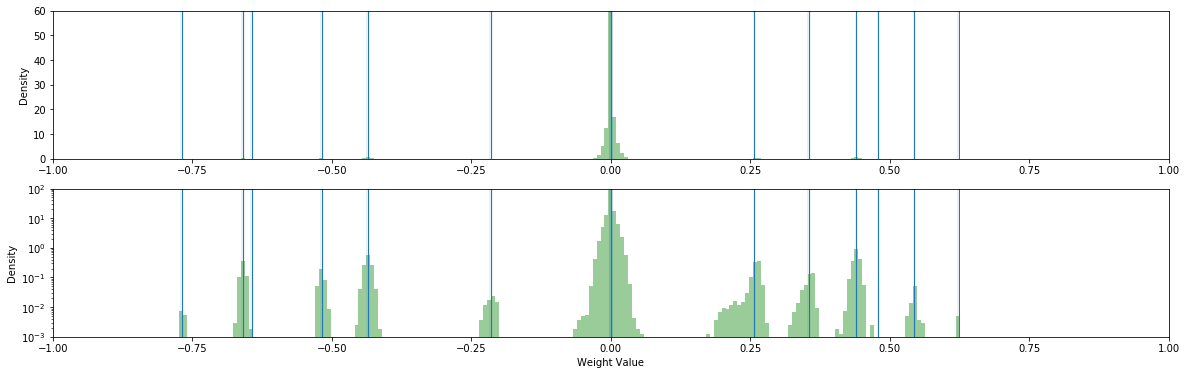

Original: 98.26% - Retrain: 95.41% - Prune: 95.17% - Sparsity: 96.12%
Epoch: 30. Loss: -5375.52


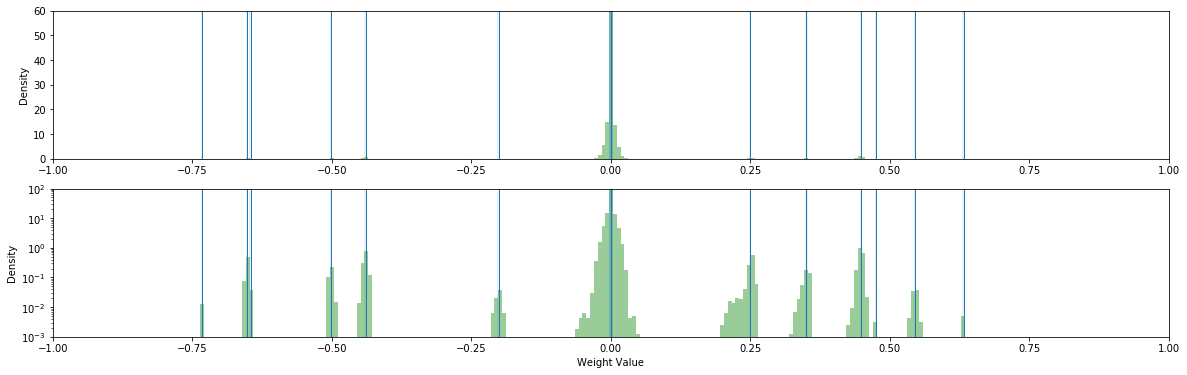

Original: 98.26% - Retrain: 95.42% - Prune: 95.30% - Sparsity: 96.12%
Epoch: 40. Loss: -5375.57


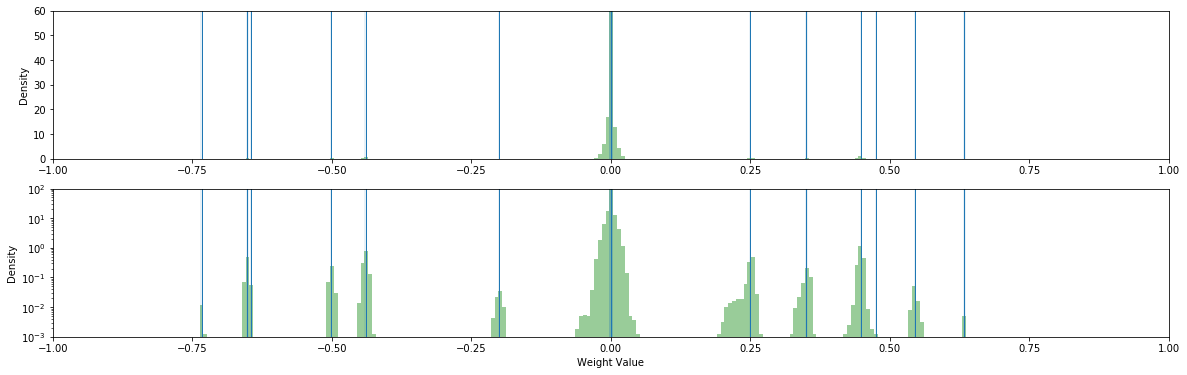

Original: 98.26% - Retrain: 95.34% - Prune: 95.30% - Sparsity: 96.12%
Epoch: 50. Loss: -5375.62


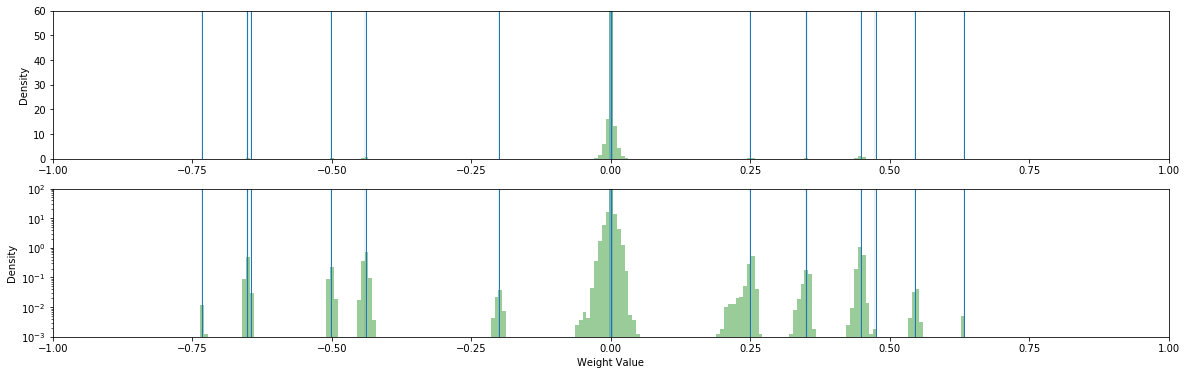

Original: 98.26% - Retrain: 95.31% - Prune: 95.30% - Sparsity: 96.12%


In [109]:
exp_name = "{}_a{}_b{}_r{}_t{}_m{}_kdT{}_{}".format(layer_model.name, alpha, beta, retraining_epochs, tau, int(mixtures), int(temp), data_size)
gmp = GaussianMixturePrior(mixtures, [x for x in layer_model.parameters()], 0.99, zero_ab = (zalpha, zbeta), ab = (alpha, beta), scaling = False)
gmp.print_batch = False
criterion = nn.MSELoss()
opt = torch.optim.Adam([
    {'params': layer_model.parameters(), 'lr': 5e-4},
    {'params': [gmp.means], 'lr': 3e-4},
    {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])#log precisions and mixing proportions

for epoch in range(50):
    #mean = mean_mult[epoch]
    #mean = 50000
    #beta = mean/var
    #alpha = mean * beta
    #gmp.ab = (alpha, beta)
    
    layer_model, loss = retrain_sws_epoch(layer_model, gmp, opt, criterion, loader, tau, temp)

    if (trueAfterN(epoch, 10)):
        print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
        show_sws_weights(model = layer_model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
        layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)
